In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

# Loading maps

In [2]:
import mapping.utils as maps
import matplotlib.pyplot as plt

In [3]:
FILE = './data/file150.json' # Sample file

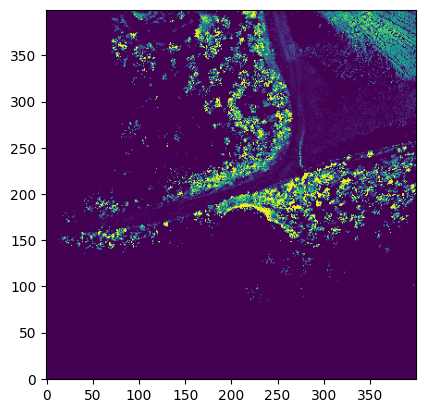

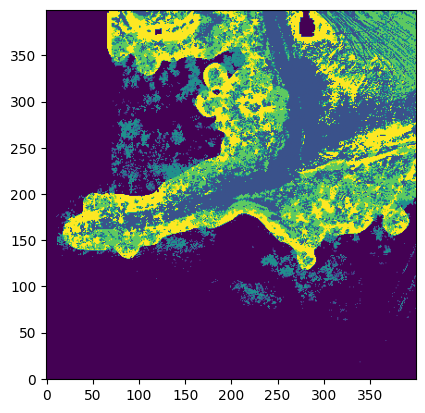

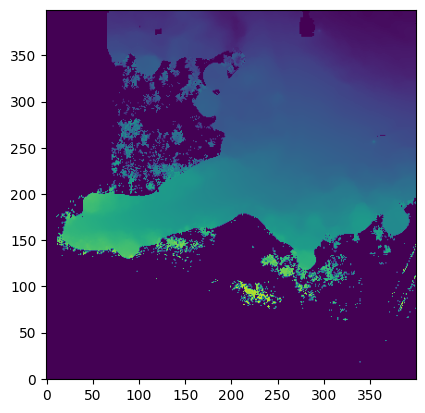

In [4]:
object_map, observed_map, terrain_map, origin_x, origin_y, resolution, num_x, num_y = maps.load_layers(FILE)

plt.imshow(object_map, origin ='lower')
plt.show()

plt.imshow(observed_map, origin ='lower')
plt.show()

plt.imshow(terrain_map, origin ='lower')
plt.show()

## Finding a path with a Rapidly-exploring Random Tree (RRT)

In [5]:
import sys
from pathlib import Path

PATH_TO_SHARED_LIB = str(Path("").resolve()) + "/rrt_sharp/src/rrt_sharp/build/"
sys.path.append(PATH_TO_SHARED_LIB)

from rrt_sharp_py import *

In [6]:
# Configure RRTSharp object

# Create Map dimension
rrt_sharp = RRTSharp([2, 3, 4])

rrt_sharp.set_map_info(origin_x, origin_y, resolution, num_x, num_y)
rrt_sharp.set_object_map(object_map.flatten().tolist())
rrt_sharp.set_observed_map(observed_map.astype(int).flatten().tolist())
rrt_sharp.set_terrain_map(terrain_map.flatten().tolist())
rrt_sharp.set_start_state(227.0, -143.0, 180.0)
rrt_sharp.set_goal_state(114.0, -250.0, 300.0)
rrt_sharp.set_stop_radius(5.0)

# Run RRT

rrt_sharp.init()
rrt_sharp.run()

Reached
Reached
Reached
Reached
Reached
Reached
Reached
numNodes: 4726, numChildren: 4726
total: 578.339 ms


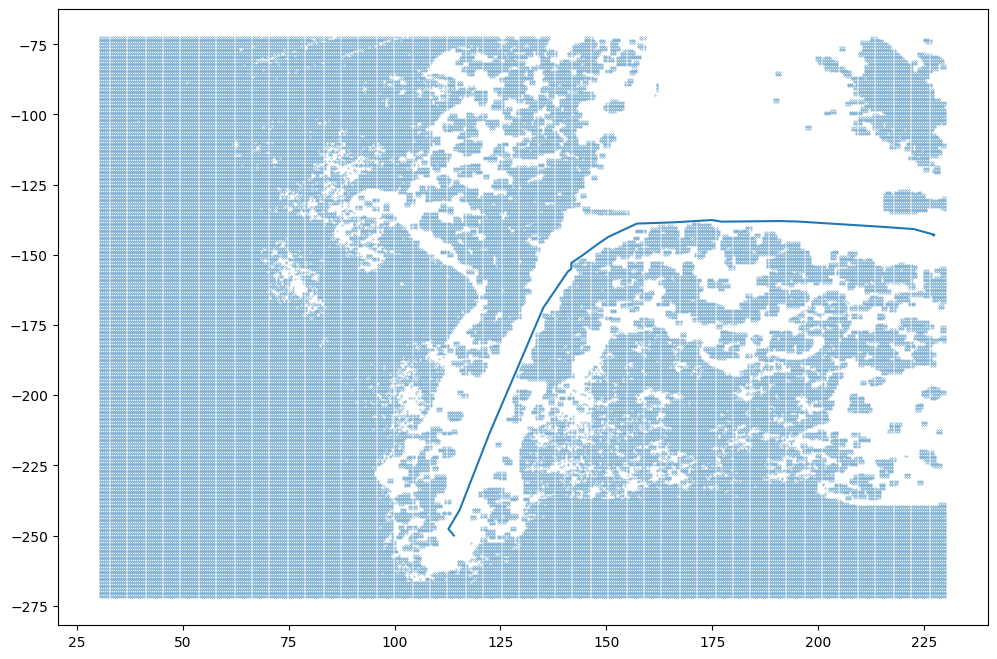

In [7]:
traj_x = np.array(list(rrt_sharp.get_trajectory_x()))
traj_y = np.array(list(rrt_sharp.get_trajectory_y()))

search_space_x = list(rrt_sharp.get_search_space_x())
search_space_y = list(rrt_sharp.get_search_space_y())

fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(traj_x, traj_y)
plt.show()

# Simulating dynamics

In [8]:
import optimization.bicycle_model as bicycle_model
from optimization.utils import *
import optimization.quadratic as qr

## Simple example

In [9]:
model = bicycle_model.BicycleModelParameters(dt=0.02, max_steering_angle=2, min_steering_angle=-2, wheelbase=2.96)

# state: x, y, yaw, velocity

nx = 4
x0 = np.array([0, 0, 0, 0.2]) # initial state

# controls: acceleration, steering_angle

nu = 2
U = np.array([[2, 0], [1.2, 0.3], [1.4, 0.4], [0, 0.2]])

N = U.shape[0]+1

# Simulate dynamics

params = OptimizationParameters(nx=nx, nu=nu, N=N, model=model)

# Caution: no constraints on the controls are handled by the forward pass/dynamics
X = simulate(x0, U, bicycle_model.discrete_dynamics, params)

print(X)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-01]
 [4.40000000e-03 0.00000000e+00 0.00000000e+00 2.40000000e-01]
 [9.43999604e-03 6.32049036e-06 2.50813175e-03 2.64000000e-01]
 [1.49999395e-02 3.13839370e-05 6.50752707e-03 2.92000000e-01]
 [2.08398159e-02 6.93876268e-05 6.50752707e-03 2.92000000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


## Using iLQR to follow reference trajectory

Now, we need to convert `traj_x` and `traj_y` from RRT to corresponding `Xref` and `Uref` with correct sizes

In [10]:
N = traj_x.shape[0] # size determined by RRT

In [58]:
# problem size 
dt = model.dt

# create reference trajectory 
Xref, Uref = np.array([traj_x, traj_y, np.zeros(N), np.ones(N)]).T, np.zeros((N-1, nu))

# Guess yaw angles
for k in range(len(Xref) - 1):
    p1 = Xref[k]
    p2 = Xref[k+1]
    yaw = np.arctan2(p2[1] - p1[1], p2[0] - p1[0]) # tan^-1(Δy/Δx)
    Xref[k, 2] = yaw
Xref[N-1, 2] = Xref[N-2, 2] # keep same yaw at the end

for k in range(len(Xref) - 1):
    # estimating the yaw rate very roughly
    diff_yaw = Xref[k+1, 2] - Xref[k, 2]
    if abs(diff_yaw) < 1:
        Uref[k, 1] = 0
    elif diff_yaw > 0: # we need to increase yawq
        Uref[k, 1] = 2.
    else: # we need to decrease yaw
        Uref[k, 1] = -2.8

# tracking cost function
Q = np.diag([1, 1, 0, 0]) # no cost for yaw nor velocity
R = 0 * np.eye(nu) # no cost for controls
Qf = 10*Q

# the params needed by iLQR 
qrParams = qr.QR(
    Q=Q,
    Qf=Qf,
    R=R,
    Xref=Xref,
    Uref=Uref,
    nx=params.nx,
    nu=params.nu,
    N=N,
    model=params.model
)

# initial condition 
x0 = Xref[0]

# initial guess controls 
U = Uref + np.linspace(0.1, 1, N-1)[:, None]#+ .0001*np.random.rand(*Uref.shape)

# solve with iLQR
X, U, K = qr.iLQR(x0, U, bicycle_model.discrete_dynamics, bicycle_model.discrete_dynamics_grad, qrParams)

iLQR failed


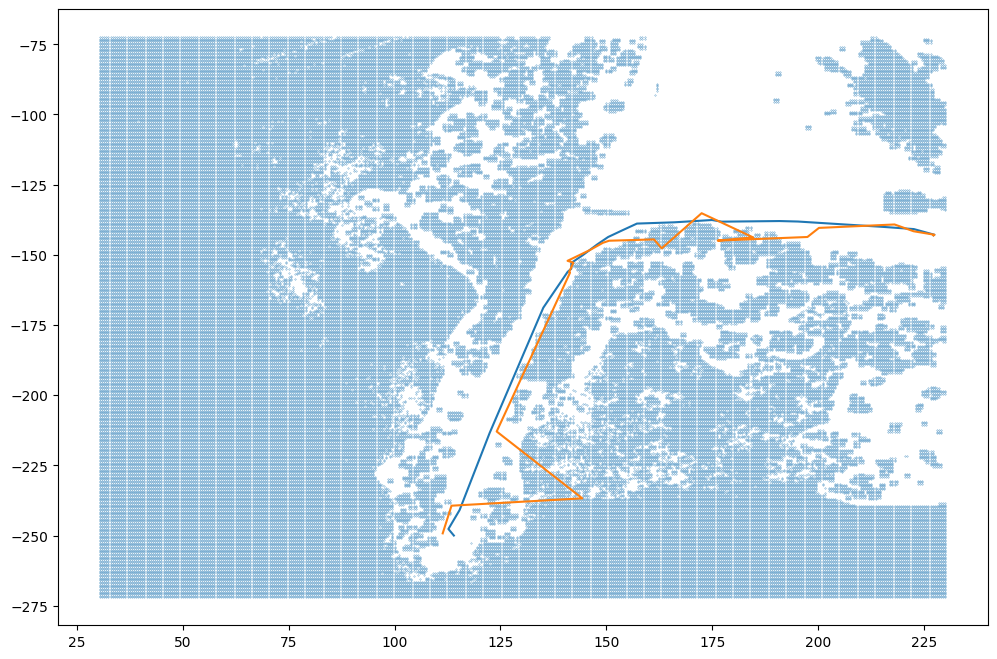

In [59]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(Xref[:, 0], Xref[:, 1])
plt.plot(X[:, 0], X[:, 1])
plt.show()